In [2]:
# Import packages
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

train_x_raw = pd.read_csv("X_train.csv", low_memory = True, index_col=0)
train_y_raw = pd.read_csv("y_train.csv", low_memory = True, index_col=0)
test_x_raw = pd.read_csv("X_test.csv", low_memory=True, index_col=0)

df_train = pd.DataFrame(train_x_raw)
df_test = pd.DataFrame(test_x_raw)
df_y = pd.DataFrame(train_y_raw)

Add all of the preprocessing below

## Variable 1 - 146 Preprocessing

In [3]:
columns_to_drop = ['c_abrv', 'f46_IT', 'v72_DE', 'v73_DE', 'v74_DE', 'v75_DE', 'v76_DE', 'v77_DE', 'v78_DE', 'v79_DE']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

## Variable 147 - 292 Preprocessing 

In [4]:
### Function to find the targeted colname
def find_colname(data, target):
    temp = []
    for varname in data.columns:
        if varname.endswith(target):
            temp.append(varname)
    return(temp)

merge_colname = find_colname(train_x_raw, '_11c')
print(find_colname(train_x_raw, 'c'))
print(find_colname(train_x_raw, '_r'))

def merge_columns(dat, colname):
    for name in colname:
        name_org = name.replace("_11c", "")
        dat.loc[dat[name_org] == -4, name_org] = dat.loc[dat[name_org] == -4, name]

['v30c', 'v45c', 'v133_11c', 'v134_11c', 'v135_11c', 'v136_11c', 'v137_11c', 'v138_11c', 'v139_11c', 'v140_11c', 'v141_11c']
['age_r', 'v228b_r', 'v231b_r', 'v233b_r', 'v239_r', 'v242_r', 'v243_r', 'v251b_r', 'v252_r', 'v261_r', 'v262_r', 'v263_r', 'v276_r', 'v278c_r', 'v279c_r', 'v279d_r', 'v281a_r']


## Variable 293 - 438 Preprocessing

In [5]:
## removed string type data
df_train.drop('v228b', inplace=True, axis=1) 
df_test.drop('v228b', inplace=True, axis=1) 

df_train.fillna({'v228b_r': -3}, inplace=True)
df_test.fillna({'v228b_r': -3}, inplace=True)

df_train.drop('v231b', inplace=True, axis=1) 
df_test.drop('v231b', inplace=True, axis=1)

df_train.fillna({'v231b_r': -3}, inplace=True)
df_test.fillna({'v231b_r': -3}, inplace=True)

df_train.drop('v233b', inplace=True, axis=1)
df_test.drop('v233b', inplace=True, axis=1)

df_train.fillna({'v233b_r': -3}, inplace=True)
df_test.fillna({'v233b_r': -3}, inplace=True)

df_train.drop('v251b', inplace=True, axis=1)
df_test.drop('v251b', inplace=True, axis=1) 

df_train.fillna({'v251b_r': -3}, inplace=True)
df_test.fillna({'v251b_r': -3}, inplace=True)

df_train.drop('f252_edulvlb_CH', inplace=True, axis=1)
df_test.drop('f252_edulvlb_CH', inplace=True, axis=1)

## removed the column having 'DE'
df_train.drop(list(df_train.filter(regex='DE')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='DE')), axis=1, inplace=True)

## removed the column having 'GB'
df_train.drop(list(df_train.filter(regex='GB')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='GB')), axis=1, inplace=True)

df_train.drop('v281a', inplace=True, axis=1)
df_test.drop('v281a', inplace=True, axis=1)

# Simple Model Run

In [6]:
# Prepare the DMatrix 
# Convert to 'category' type
# Make sure the conversion is applied to df_train and df_test if they are used for DMatrix
df_train['v275b_N2'] = df_train['v275b_N2'].astype('category')
df_train['v275b_N1'] = df_train['v275b_N1'].astype('category')
df_test['v275b_N2'] = df_test['v275b_N2'].astype('category')
df_test['v275b_N1'] = df_test['v275b_N1'].astype('category')

label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)
# When creating DMatrix, enable categorical support
dtrain = xgb.DMatrix(df_train, label=df_y, enable_categorical=True)
dtest = xgb.DMatrix(df_test, enable_categorical=True)

# Set XGBoost parameters 
params = {
    'max_depth': 6,
    'eta': 0.01,
    'objective': 'multi:softprob',
    'num_class': 5,  # We have 5 classes: 0, 1, 2, 3, 4
    'eval_metric': 'mlogloss',
}
num_boost_round = 400  # Number of boosting rounds

bst = xgb.train(params, dtrain, num_boost_round)
y_test_probs = bst.predict(dtest)

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

submission_df = pd.DataFrame(y_test_probs, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
# submission_file = 'submission.csv'
submission_file = 'submission.xlsx'
## submission_df.to_csv(submission_file,lineterminator=None, index=False)
with pd.ExcelWriter(submission_file) as writer:
    submission_df.to_excel(writer, sheet_name="Sheet1") 


In [7]:
# Neural Network
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
pd.crosstab(index=df_train['v275b_N2'], columns='count')

col_0,count
v275b_N2,
-1,17
-4,1817
AL01,345
AL02,443
AL03,406
AM01,472
AM02,313
AM03,242
AM04,230


In [9]:
label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)

df_train.drop('v275b_N2', inplace=True, axis=1)
df_test.drop('v275b_N2', inplace=True, axis=1)

df_train.drop('v275b_N1', inplace=True, axis=1)
df_test.drop('v275b_N1', inplace=True, axis=1) 

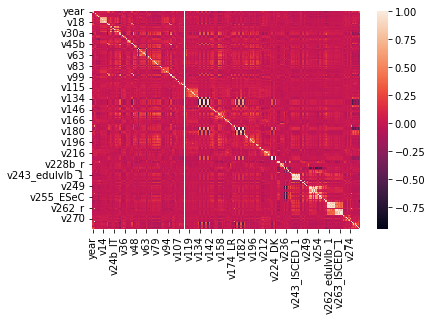

In [11]:
sns.heatmap(df_train.corr());

In [12]:
corr = df_train.corr()
corr.loc[np.where(corr<0.8, 1, 0)==1].columns

Index(['year', 'fw_start', 'fw_end', 'country', 'v1', 'v2', 'v3', 'v4', 'v5',
       'v7',
       ...
       'v278a', 'v278b', 'v278c_r', 'v279a', 'v279b', 'v279c_r', 'v279d_r',
       'v280', 'v281a_r', 'v282'],
      dtype='object', length=399)

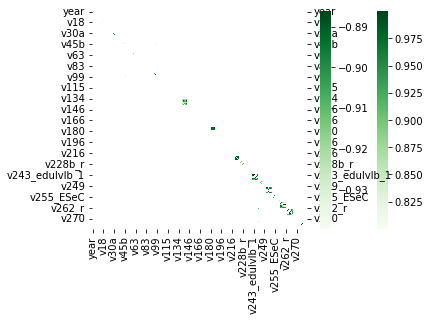

[('year', 'fw_start'), ('year', 'fw_end'), ('fw_start', 'fw_end'), ('country', 'v243_cs'), ('country', 'v275c_N2'), ('country', 'v275c_N1'), ('v12', 'v17'), ('v12', 'v18'), ('v13', 'v17'), ('v13', 'v18'), ('v14', 'v17'), ('v16', 'v17'), ('v16', 'v18'), ('v17', 'v18'), ('f20', 'v20'), ('v20a', 'v20b'), ('f30a', 'v30a'), ('v30b', 'v30c'), ('f45a', 'v45a'), ('v45b', 'v45c'), ('v45b', 'v96a'), ('v45b', 'v96b'), ('v45c', 'v96a'), ('v45c', 'v96b'), ('v51', 'v53'), ('v59', 'v60'), ('f96', 'v96'), ('v96a', 'v96b'), ('v133_11c', 'v134_11c'), ('v133_11c', 'v135_11c'), ('v133_11c', 'v136_11c'), ('v133_11c', 'v137_11c'), ('v133_11c', 'v138_11c'), ('v133_11c', 'v139_11c'), ('v133_11c', 'v140_11c'), ('v133_11c', 'v141_11c'), ('v134_11c', 'v135_11c'), ('v134_11c', 'v136_11c'), ('v134_11c', 'v137_11c'), ('v134_11c', 'v138_11c'), ('v134_11c', 'v139_11c'), ('v134_11c', 'v140_11c'), ('v134_11c', 'v141_11c'), ('v135_11c', 'v136_11c'), ('v135_11c', 'v137_11c'), ('v135_11c', 'v138_11c'), ('v135_11c', 'v139_

In [17]:
fig, ax = plt.subplots()
##kot1 = corr[corr>= 0.8]
##kot2 = corr[corr<= -0.8]
mask1 = np.logical_or(corr <= 0.8, corr == 1)
mask2 = np.logical_or(corr >= -0.8, corr == -1)

kot1 = corr.mask(mask1)
kot2 = corr.mask(mask2)
sns.heatmap(kot1, cmap="Greens")
ax2 = ax.twinx()
sns.heatmap(kot2, cmap="Greens")
plt.show()
pairs = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):  # i+1 to exclude self-correlation
        if (0.8 <= corr.iloc[i, j] <= 1) or (-1 <= corr.iloc[i, j] <= -0.8):
            pairs.append((corr.columns[i], corr.columns[j]))
print(pairs)

In [20]:
set_pairs = []

for e in pairs:
     set_pairs.append(set(e))
set_pairs

[{'fw_start', 'year'},
 {'fw_end', 'year'},
 {'fw_end', 'fw_start'},
 {'country', 'v243_cs'},
 {'country', 'v275c_N2'},
 {'country', 'v275c_N1'},
 {'v12', 'v17'},
 {'v12', 'v18'},
 {'v13', 'v17'},
 {'v13', 'v18'},
 {'v14', 'v17'},
 {'v16', 'v17'},
 {'v16', 'v18'},
 {'v17', 'v18'},
 {'f20', 'v20'},
 {'v20a', 'v20b'},
 {'f30a', 'v30a'},
 {'v30b', 'v30c'},
 {'f45a', 'v45a'},
 {'v45b', 'v45c'},
 {'v45b', 'v96a'},
 {'v45b', 'v96b'},
 {'v45c', 'v96a'},
 {'v45c', 'v96b'},
 {'v51', 'v53'},
 {'v59', 'v60'},
 {'f96', 'v96'},
 {'v96a', 'v96b'},
 {'v133_11c', 'v134_11c'},
 {'v133_11c', 'v135_11c'},
 {'v133_11c', 'v136_11c'},
 {'v133_11c', 'v137_11c'},
 {'v133_11c', 'v138_11c'},
 {'v133_11c', 'v139_11c'},
 {'v133_11c', 'v140_11c'},
 {'v133_11c', 'v141_11c'},
 {'v134_11c', 'v135_11c'},
 {'v134_11c', 'v136_11c'},
 {'v134_11c', 'v137_11c'},
 {'v134_11c', 'v138_11c'},
 {'v134_11c', 'v139_11c'},
 {'v134_11c', 'v140_11c'},
 {'v134_11c', 'v141_11c'},
 {'v135_11c', 'v136_11c'},
 {'v135_11c', 'v137_11c'},
 

In [32]:
x = list(set().union(*set_pairs))

In [ ]:
for e in x:
    